# **Finding the Lane Lines**

This book explores creating a sliding window algorithm to fit a polyline to a thresholded image.

## **Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from src.calibration import *
from src.transform import *

In [2]:
calibration = Calibration('camera_cal/', (9, 6))
transform = Transform()

## **Motivation**

The binary threshold image that was created in the last book defined the lane lines well. If we wanted to, we could change the white pixels to red and mask it onto the originak image and we would have the lines drawn on the image.

The problem is the same as the one we tried to work with in the tresholding book, the road and camera conditions have a great degree of variation. Not every image is clear with a lot of contrast between the road and markers. In some cases the lane markers might not exist for a small portion of the road at all. The perspective transformation also has distortion near the top of the image which alters the colour properties. This means that not every pixel of the line will be detected, resulting in a choppy looking line. 

The best thing to do here is to use the information we _are_ able to extrapolate from thresholding and estimate a line to give us a good approximation of the lane markers.

## **Setup**

Let's take a look at an image where a white lane marker is missing on the right line.

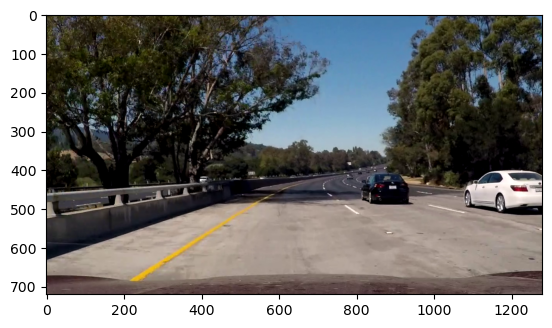

In [3]:
orig_img = cv2.imread('output_media/debug/problem_frames/pf_11.png')
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

plt.imshow(orig_img)

First, let's remove camera distortion and transform it to top-view.

Text(0.5, 1.0, 'Top-View')

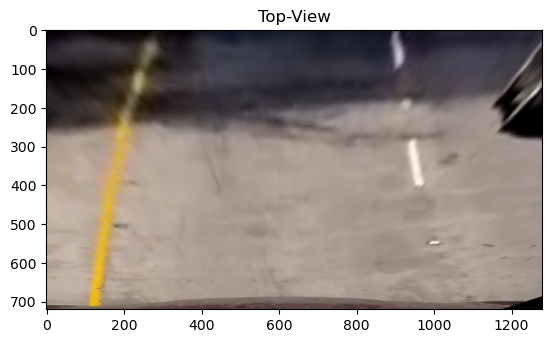

In [4]:
cal_img = calibration.undistort(orig_img)
bev_img = transform.orig_to_bev(cal_img)

plt.imshow(bev_img)
plt.title('Top-View')

Now lets apply thresholding and see what we can extract from it.

Text(0.5, 1.0, 'Binary Threshold')

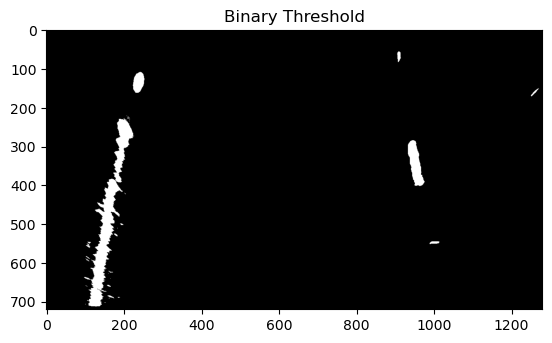

In [5]:
# Get colour spaces
hls = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HSV)

# Define threshold range bounds
lightness_lower = np.array([195])
lightness_upper = np.array([255])
yellow_lower = np.array([int(40 / 2), int(0.00 * 255), int(0.50 * 255)])
yellow_upper = np.array([int(50 / 2), int(1.00 * 255), int(1.00* 255)])

# Threshold colour spaces
lightness = cv2.inRange(hls[:, :, 1], lightness_lower, lightness_upper)
yellow = cv2.inRange(hsv, yellow_lower, yellow_upper)

# Combine thresholds
output = lightness | yellow

# Plot image
plt.imshow(output, cmap='gray')
plt.title('Binary Threshold')

There is a bit of noise in the yellow line and the top marker for the white line isn't fully captured. Not a great situation, but we have enough information where we can estimate a line that fits well.

## **Sliding Window Alogrithm**

As a quick summary before we dive into the details, the sliding window algorithm aims to find all of the x and y coordinates of the lane line pixels by sliding a window bottom to top along the lane line. The window will try to encapsulate only the pixels of the line and nothing else.

From the image above it might seem easier to split the image in half such that one image is the left line and the other is the right line and just fit a line on each image. The issue primarily comes from the issue of noise.

No matter the algorithm, noise will always appear. For us, things like directional markers or objects on the road might be included after thresholding and the noisy pixels would be used in the line calculations.

The sliding window will also only follow the lane markers, and nothing else. That means if there is a sharp turn or atypical curvature in the markers, the window will be capable of following it and dodge the noise.

### **Hyperparameters**

Before starting the algorithm, it is important to define a few hyperparameters that we might want to adjust as we go on.

The **window height** and **margin** defines the precision of the algorithm through how much information the algorithm caputres each time the window slides. A **larger height** ensures that you can capture succeeding markers if there is a gap within the lane line. Too **small** of a **height** and the algorithm becomes sensitive to gaps, especially if the road curves. A **larger margin** can help remedy small window heights at the cost of additional noise while a **smaller margin** might not capture enough information.

>**Note:** The margin is measured from the center of the window to the side edge of the window (2 * margin = window width).

The **number of windows** (or the number of times to slide the window) is closely related to the window height. If the window height is small, we can add **additional** windows. Or if the window height is large we an **reduce** the number of windows. Typically the best number of windows is one that covers the height of the image, but sometimes the perspective transformation might add noise to the top portion of the image and skew the line calculation.

To reduce the effect of any noise that does end up passing through to the windows, we can specifiy a **minimum number of pixels** that need to be in the window before we update the center points for the next window. If the number is too low the noise will have a greater effect on the positioning of the window, but if it is too low smaller lane markers or reflectors might not help to update the window position.

In [6]:
# Define the hyperparameters
n_windows = 9
window_height = int(output.shape[0] // n_windows)
margin = 75
min_pixels = 50

### **Window Starting Locations**

Before we create the windows, we need to know where to place the first window. We can leverage the fact that our threshold image is binary and create a histogram showing us which the number of pixels at each x-coordinate for the lower half of the image. If we then split the histogram in half vertically, we can find the x-coordinate that contains the maximum number of pixels. On average, this location will be the best starting point for the algorithm.

On the image below, a histogram of the number of pixels for each x-coordinate has been overlayed on the threshold image. We see that there are two clearly defined peaks. One for the left line, the other for the right. 

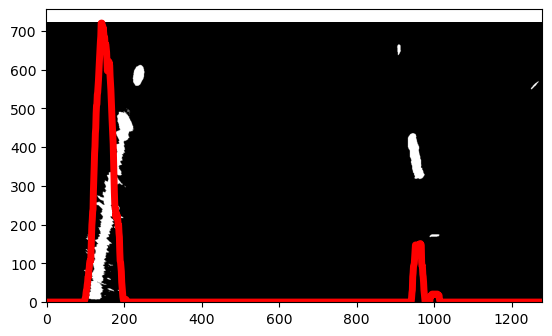

In [7]:
# Create a histogram of the number of pixels for each x-coordinate for the bottom half of the image
hist = np.sum(output[output.shape[0] // 2:, :], axis=0)

# Conversion and scalling for plotting
hist_scaled = hist.astype('float32')
hist_scaled *= (output.shape[0]) / hist.max()

# Plot histogram over image
implot = plt.imshow(np.flipud(output), origin='lower', cmap='gray')
plt.plot(hist_scaled, linewidth=5, color='red')
plt.show()

Also note that the right line doesn't have a solid marker near the bottom of the image, but the peak is pointing to the next well defined marking. That is the benefit of using this approach, if lane marker information is missing the peaks will always guide us to wards visible markers. Let define the starting locations below.

In [8]:
# Define midpoint of historgram
midpoint = int(hist.shape[0] / 2)

# Define base location of left and right lines based on the peak of the histograms to the 
# left and right of the midpoint
left_x_base = np.argmax(hist[:midpoint])
right_x_base = np.argmax(hist[midpoint:]) + midpoint

print(f'The base x-coordinate for the left and right window is {left_x_base} and {right_x_base} respectively.')

The base x-coordinate for the left and right window is 141 and 964 respectively.


We can define the y-coordinate of the center of the first window as one-half of the window height above the bottom of the image. Now that we have the center coordinates of the first windows, we can create three pointers (`left_x_curr`, `right_x_curr`, and `y_curr`) to track the coordinates of the center of the windows as they slide up. 

In [9]:
# Create pointer for the centers of the windows
left_x_curr = left_x_base
right_x_curr = right_x_base
y_curr = output.shape[0] - window_height // 2

### **Data Arrays**

We will need to get the x and y corrdinates of the non-zero pixels in the threshold image which will be conditionally indexed to extract the coordinates of the pixels in the window.

In [10]:
# Get x and y poisitions of all non-zero pixels in image
non_zero = output.nonzero()
non_zero_x = np.array(non_zero[1])
non_zero_y = np.array(non_zero[0])

Next we can create lists to store the x and y coordinates of the pixels that were conditionally indexed.

In [11]:
# Create empty lists to store lane line pixel locations
left_x, left_y, right_x, right_y = [], [], [], []

### **Condtional Indexing Function**

Before moving to the algorithm loop, we can define a helper function which will make the code more legible. The `find_pixels` function is used to extract the pixels that are within the bounds of the window. It takes the **center** of a window and calculates the top-left and bottom-right corners of the window using the **margin** and **window_height**. These define the bounds of the window. Then two conditions are created for conditional indexing. `cond_x` and `cond_y` are used to get the respective x and y coordinates of the **non-zero** pixels between the top-left and bottom-right corners of the window. The targeted x and y coordinates are then returned.

In [12]:
def find_pixels(center, margin, window_height, non_zero_x, non_zero_y):
    
    # Define top-left and bottom-right x and y coords for window boundry
    top_left = (center[0] - margin, center[1] - (window_height // 2))
    bottom_right = (center[0] + margin, center[1] + window_height // 2)
    
    # Create conditions for array indexing
    cond_x = (non_zero_x >= top_left[0]) & (non_zero_x <= bottom_right[0])
    cond_y = (non_zero_y >= top_left[1]) & (non_zero_y <= bottom_right[1])

    # Index non-zero array to only take pixels within the window boundries
    targets_x = non_zero_x[cond_x & cond_y]
    targets_y = non_zero_y[cond_x & cond_y]

    return targets_x, targets_y, top_left, bottom_right

### **Sliding Window**

Now we have everything we need to implement the sliding window algorithm. The loop works as follow. First we define the center of the window with the current pointers for the center coordinates. Next we pass that information to the pixels in the left and then right windows. Those pixels are then added to the master list of x and y coordinates. The last step in the loop is to update the pointers. `x_curr` for the next windows are updated using the mean of the x-coordinates found in the current window, and `y_curr` is updated by the window height.

In [13]:
# Create a copy of the threshold image in the RGB colour space for plotting
out_img = cv2.cvtColor(output, cv2.COLOR_GRAY2RGB)

In [14]:
# Start sliding window
for _ in range(n_windows):
    # Define center coords of left and right windows
    center_left = (left_x_curr, y_curr)
    center_right = (right_x_curr, y_curr)

    # Get x and y coords of pixels that fall within the window and plot the windows
    left_window_x, left_window_y, top_left, bottom_right = find_pixels(center_left, margin, window_height, non_zero_x, non_zero_y)
    cv2.rectangle(out_img, top_left, bottom_right, color=(255, 0, 0), thickness=10)

    right_window_x, right_window_y, top_left, bottom_right = find_pixels(center_right, margin, window_height, non_zero_x, non_zero_y)
    cv2.rectangle(out_img, top_left, bottom_right, color=(255, 0, 0), thickness=10)

    # Add pixels detected in window to master lists
    left_x.extend(left_window_x)
    left_y.extend(left_window_y)
    right_x.extend(right_window_x)
    right_y.extend(right_window_y)

    # Update pointers
    if len(left_window_x) >= min_pixels:
        left_x_curr = np.int32(np.mean(left_window_x))
    if len(right_window_x) >= min_pixels:
        right_x_curr = np.int32(np.mean(right_window_x))
    y_curr -= window_height

After this looop has run, we will have the x and y coordinates to fit lines for both the left and right lane markers.

### Fitting the Polylines

We can use `numpy` to fit a second order polynomial to our collected data using their `polyfit` function.

In [15]:
left_fit = np.polyfit(left_y, left_x, 2)
right_fit = np.polyfit(right_y, right_x, 2)

Lastly, we need to evaluate the polynomial over the x-axis of the image in order to be able to draw the lines.

In [16]:
# Get x-values to evaluate with
draw_x = np.linspace(0, output.shape[1], output.shape[1])

# Evaluate the polynomials
draw_y_left = np.polyval(left_fit, draw_x)
draw_y_right = np.polyval(right_fit, draw_x)

And that's it for the sliding window algorithm!

## Plotting the Lines

Now that we have the evaluated polynomials, we can use `OpenCV` to plot them over our threshold image and see how we did.

Text(0.5, 1.0, 'Fitted Lines over Threshold Image')

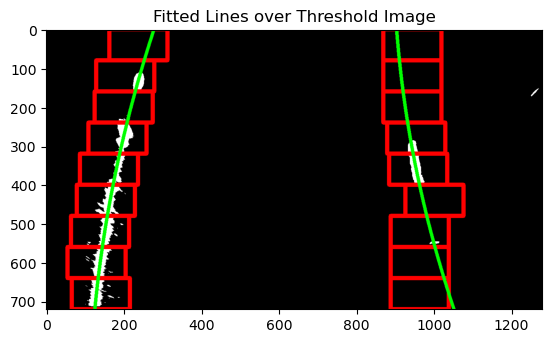

In [17]:
# Format the x and evaluated y values for plotting
draw_points_left = (np.asarray([draw_y_left, draw_x]).T).astype(np.int32)
draw_points_right = (np.asarray([draw_y_right, draw_x]).T).astype(np.int32)

# Draw the coordinates as polylines on the output image
cv2.polylines(out_img, [draw_points_left], False, (0, 255, 0), thickness=8)
cv2.polylines(out_img, [draw_points_right], False, (0, 255, 0), thickness=8)

# Show plot
plt.imshow(out_img)
plt.title('Fitted Lines over Threshold Image')

That looks great! We can see that the algorithm was able to overcome the noise issue for the left lane marker, and the missing markings for the right lane marker. All thats left now is to add the lines to our original image.

## **Adding Lines to the Original Image**

Let's first draw ths top-view of the lines on a black background.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Top-View of Fitted Lines')

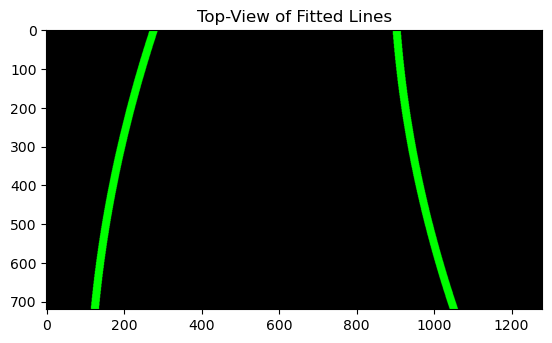

In [21]:
lines_top_img = np.zeros((out_img.shape[0], out_img.shape[1], 3))
cv2.polylines(lines_top_img, [draw_points_left], False, (0, 255, 0), thickness=20)
cv2.polylines(lines_top_img, [draw_points_right], False, (0, 255, 0), thickness=20)

plt.imshow(lines_top_img)
plt.title('Top-View of Fitted Lines')

And now we can transform the top-view into front-view.

Text(0.5, 1.0, 'Front-View of Fitted Lines')

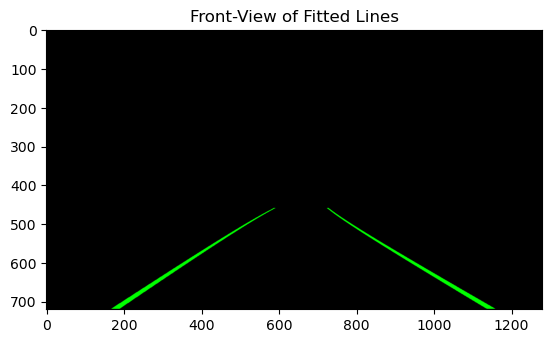

In [22]:
lines_front_img = transform.bev_to_orig(lines_top_img)
lines_front_img = lines_front_img.astype(np.uint8)

plt.imshow(lines_front_img)
plt.title('Front-View of Fitted Lines')

And finally we can overlay this onto the original image.

Text(0.5, 1.0, 'Original Image with Fitted Lines')

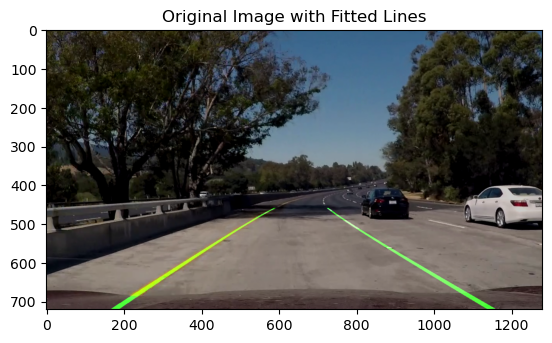

In [23]:
final_img = cv2.addWeighted(orig_img, 0.8, lines_front_img, 1.0, 0.0)

plt.imshow(final_img)
plt.title('Original Image with Fitted Lines')

That looks great! Both the left and right lines fit right on top of the original lane markers. All the notebooks up to this point contain majority of the lane detection processing. In the final notebook, we can see each step we took from beginning to end.